In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl

import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt

In [3]:
torch.random.manual_seed(42)

In [4]:
class GWDataModule(pl.LightningDataModule):

    def __init__(self, train_data_dir, val_data_dir, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.train_data_dir = train_data_dir
        self.val_data_dir = val_data_dir

    def setup(self, stage=None):
        train_transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=1),
            transforms.Resize(28),
            transforms.RandomHorizontalFlip(p=.2),
            transforms.RandomRotation(35),
            transforms.ToTensor(),
            transforms.Normalize([0.07621749,0.07365512,0.093327], 
                                 [0.037140302,0.036283262,0.04071455])
        ])
        val_transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=1),
            transforms.Resize(28),
            transforms.ToTensor(),
            transforms.Normalize([0.07621749,0.07365512,0.093327], 
                                 [0.037140302,0.036283262,0.04071455])
        ])
        self.train_ds = ImageFolder(self.train_data_dir, transform=train_transform)
        self.val_ds = ImageFolder(self.val_data_dir, transform=train_transform)

        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=4, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=4, pin_memory=True)

In [5]:
GW_dts = GWDataModule('/home/felipe/GW_playgorund/new project/data Osvaldo/classifier_o3/train/', 
                      '/home/felipe/GW_playgorund/new project/data Osvaldo/classifier_o3/val/', batch_size=32)

In [6]:
GW_dts.setup()

In [7]:
bt_x, bt_y = next(iter(GW_dts.train_dataloader()))

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.07621749,0.07365512,0.093327])
    std = np.array([0.037140302,0.036283262,0.04071455])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [9]:
grid_size = 4
rnd_idx = [i.item() for i in np.random.randint(0, len(bt_x),4)]
x_grid = [bt_x[i] for i in rnd_idx]
y_grid = [bt_y[i] for i in rnd_idx]

In [10]:
x_grid = make_grid(x_grid, nrow=grid_size, padding=1)

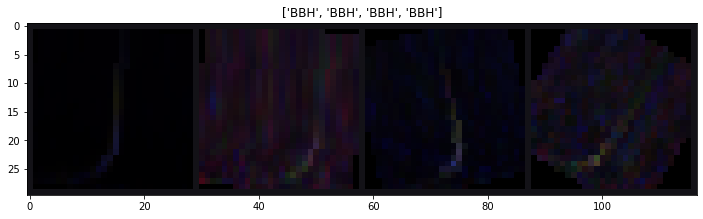

In [11]:
plt.figure(figsize=(12,8))
imshow(x_grid, title=[GW_dts.train_ds.classes[i] for i in y_grid])

In [12]:
def squared_euclidean_distance(a, b):
    b = torch.transpose(b, 0, 1)
    a2 = torch.sum(torch.square(a), dim=1, keepdims=True)
    b2 = torch.sum(torch.square(b), dim=0, keepdims=True)
    ab = torch.matmul(a, b)
    d = a2 - 2 * ab + b2
    return d


def quantize(x, centroids):
    b, c, h, w = x.shape
    # [B, C, H, W] => [B, H, W, C]
    x = x.permute(0, 2, 3, 1).contiguous()
    x = x.view(-1, c)  # flatten to pixels
    d = squared_euclidean_distance(x, centroids)
    x = torch.argmin(d, 1)
    x = x.view(b, h, w)
    return x


def unquantize(x, centroids):
    return centroids[x]

In [13]:
def _to_sequence(x):
    """shape batch of images for input into GPT2 model"""
    x = x.view(x.shape[0], -1)  # flatten images into sequences
    x = x.transpose(0, 1).contiguous()  # to shape [seq len, batch]
    return x

In [14]:
from QGPT2 import GPT2

In [15]:
class ImageGPT(pl.LightningModule):
    def __init__(
        self,
        centroids,
        embed_dim=16,
        num_heads=2,
        num_layers=1,
        num_pixels=28,
        num_vocab=16,
        num_classes=10,
        classify=False,
        learning_rate=3e-3,
        steps=10_000,
        warmup_steps=500,
        **kwargs,
    ):
        super(ImageGPT, self).__init__()
        self.save_hyperparameters()
        self.gpt = GPT2(
            embed_dim=embed_dim,
            heads=num_heads,
            layers=num_layers,
            num_positions=num_pixels * num_pixels,
            vocab_size=num_vocab,
            num_classes=num_classes,
            num_qubits = 6, 
            num_qc_layers = 2
        )

        self.centroids = nn.Parameter(
            torch.from_numpy(np.load(centroids)), requires_grad=False
        )
        self.criterion = nn.CrossEntropyLoss()
        self.classify = classify
        self.learning_rate = learning_rate
        self.steps = steps
        self.warmup_steps = warmup_steps
        self.acc = pl.metrics.Accuracy()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.gpt.parameters(), lr=self.learning_rate)

        # no learning rate schedule for fine-tuning
        if self.classify:
            return optimizer

        scheduler = {
            "scheduler": LambdaLR(
                optimizer, learning_rate_schedule(self.warmup_steps, self.steps)
            ),
            "interval": "step",
        }
        return [optimizer], [scheduler]

    def forward(self, x):
        #x = quantize(x, self.centroids)
        #x = _to_sequence(x)
        return self.gpt(x, self.classify)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = quantize(x, self.centroids)
        x = _to_sequence(x)
        
        clf_logits, logits = self(x)
        clf_loss = self.criterion(clf_logits, y)
        gen_loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))
        # joint loss for classification
        loss = clf_loss + gen_loss
        #self.log('train_loss', loss)
        #self.log('train_acc', self.acc(clf_logits, y))
        #tensorboard = self.logger.experiment
        #tensorboard.add_graph(self, x)
        return {'train_loss': loss, 'clf_logits': clf_logits, 'targets':y}
    
    def training_step_end(self, outputs):
        train_acc = self.acc(outputs['clf_logits'], outputs['targets'])
        self.log('train_loss', outputs['train_loss'])
        self.log('train_acc', train_acc*100)

    def validation_step(self, batch, batch_idx):
        x, y = batch

        x = quantize(x, self.centroids)
        x = _to_sequence(x)

        clf_logits, logits = self.gpt(x, classify=True)
        clf_loss = self.criterion(clf_logits, y)
        gen_loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))
        # joint loss for classification
        loss = clf_loss + gen_loss
        
        return {'val_loss':loss, 'clf_logits':clf_logits, 'val_targets':y}
    
    def validation_step_end(self, outputs):
        val_acc = self.acc(outputs['clf_logits'], outputs['val_targets'])
        self.log('val_loss', outputs['val_loss'])
        self.log('val_acc', val_acc*100)


    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

In [16]:
model = ImageGPT('/home/felipe/GW_playgorund/new project/data Osvaldo/centroids.npy', steps=25_000, num_classes=3, classify=True)

In [17]:
trainer = pl.Trainer(gpus=1, num_processes=4, max_epochs=1, progress_bar_refresh_rate=20,
                     limit_train_batches=0.1, limit_val_batches=0.1)

/home/felipe/anaconda3/envs/pennylane/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: num_processes is only used for `accelerator='ddp_cpu'`. Ignoring it.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [18]:
trainer.fit(model, GW_dts)


  | Name      | Type             | Params
-----------------------------------------------
0 | gpt       | GPT2             | 23.1 K
1 | criterion | CrossEntropyLoss | 0     
2 | acc       | Accuracy         | 0     
-----------------------------------------------
23.1 K    Trainable params
48        Non-trainable params
23.2 K    Total params
INFO:lightning:
  | Name      | Type             | Params
-----------------------------------------------
0 | gpt       | GPT2             | 23.1 K
1 | criterion | CrossEntropyLoss | 0     
2 | acc       | Accuracy         | 0     
-----------------------------------------------
23.1 K    Trainable params
48        Non-trainable params
23.2 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/felipe/anaconda3/envs/pennylane/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: training_step returned None if it was on purpose, ignore this warning...
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

/home/felipe/anaconda3/envs/pennylane/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1